# setting the problem


### 123

### initial density distribution



In [187]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.fftpack import fft, fftshift
from sklearn import preprocessing


v0 = 3.5;  #activation energy
rho = 0.05; #resistivity with zero vacancies 
n = 100; #nummber of nodes
time = 100; #number of timesteps
amp = 20 #voltage bias amplitude
 

class Node:
    def __init__(self,  rho0):
        self._delta = 10**(-4)
        self._rho0 = rho0
        self.resistivity = self._rho0 *np.exp(5*self._delta)
        
    @property
    def delta(self):
        return self._delta
    
    @delta.setter
    def delta(self, value):
        self._delta = value
        self.resistivity = self._rho0 *np.exp(5*self._delta)
 


nodes = [Node(rho) for _ in range(n)]

# generating input signal

here I used UliEngineering library
https://techoverflow.net/2018/12/31/easily-generate-sine-cosine-waveform-data-in-python-using-uliengineering/ 


!it's only available for python 3

frequency — how many wave forms should we have on the samplerate lenght

samplerate — lenght of the signal

input signal


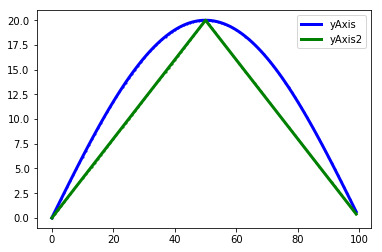

In [169]:
from UliEngineering.SignalProcessing.Simulation import sine_wave
from UliEngineering.SignalProcessing.Simulation import triangle_wave
from UliEngineering.SignalProcessing.Simulation import sawtooth



sinSignal = sine_wave(frequency=0.5, samplerate=time, amplitude=amp, offset=0)

triangleSignal = triangle_wave(frequency=0.5, samplerate=time, amplitude = amp,  phaseshift=90)

sawtoothSignal = sawtooth(frequency=1, samplerate=time, amplitude = amp/2, offset = amp/2 , phaseshift=0)

                
print('input signal')
dfInSignal =pd.DataFrame({'x': range(time), 'yAxis': sinSignal,'yAxis2': triangleSignal, 'yAxis3': sawtoothSignal})
plt.plot( 'x', 'yAxis', data=dfInSignal, marker='o', markerfacecolor='black', markersize=1, color='blue', linewidth=3)
plt.plot( 'x', 'yAxis2', data=dfInSignal, marker='o', markerfacecolor='black', markersize=1, color='green', linewidth=3)
#plt.plot( 'x', 'yAxis3', data=dfInSignal, marker='o', markerfacecolor='black', markersize=1, color='magenta', linewidth=3)

plt.legend()
plt.show()

voltageBiasReset = sinSignal
voltageBiasSet = -sinSignal



#def triangle(length, amplitude):
#     section = length // 4
#     for direction in (1, -1):
#         for i in range(section):
#            yield i * (amplitude / section) * direction
#         for i in range(section):
#             yield (amplitude - (i * (amplitude / section))) * direction


   we define bias voltage list and local voltage drop list.
   
   probability of density shift is defined as:
   
  
   $$ p_{ij} = \delta_i (1- \delta _j) e^{\left( -V_{\alpha} + \Delta {V_i} \right)} $$
  
   

pIJ list


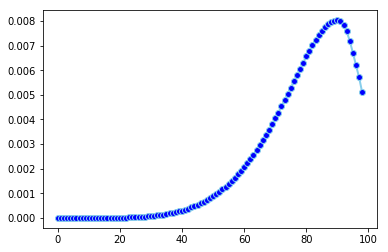

voltage local drop list 


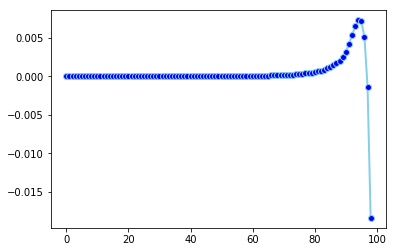

maximum probability and voltage drop at the last step


[0.008028922237345408, 0.007255758347873231]

In [201]:
voltageBias = np.zeros(time)
voltageLocalDropList = np.zeros(n-1) 
pIJlist = np.zeros(n-1)
newDeltaList = np.zeros(n)
resistanceListSet = np.zeros(time)
resistanceListReset = np.zeros(time)

sigmaNoise = 0
#generating initial OV distribution
for i in range(n): 
    nodes[i].delta = (i**5)/((n+3)**5)+ np.random.normal(0,sigmaNoise)  
    #nodes[i].delta = .5
    
#lists to store initial distribution and initial resistivity
distribution0 = [_.delta for _ in nodes];
resistivityList0 = [_.resistivity for _ in nodes];

#defining the Voltage Bias

#voltageBiasReset = triangleSignal
#voltageBiasSet = -triangleSignal




#for i in range(time):
#    voltageBiasSet[i] = -800


#function that calculates total resistance
def resistance(data):
    return sum(data[i].resistivity for i in range(len(data)))
res0 = resistance(nodes)
#res = resistance(nodes)

#local voltage drop

def voltageLocSet(data, index, tIndex, rTotal):
    return voltageBiasSet[tIndex] * data[index].resistivity / rTotal

def voltageLocReset(data, index, tIndex, rTotal):
    return voltageBiasReset[tIndex] * data[index].resistivity / rTotal


podg1 = 0
#for plus
podg2 = 0

def resetResistance(data):
    for t in range(time):
        res = resistance(data)
        for i in range(n - 1):
            voltageLocalDropList[i] = voltageLocReset(data, i + 1, t,res) - voltageLocReset(data, i, t,res)
        for i in range(n - 1):
            pIJlist[i] = data[i].delta * (1 - data[i + 1].delta) * np.exp(-v0 + voltageLocalDropList[i])
        for i in range(1, n - 1):
            newDeltaList[i] = -pIJlist[i] * data[i].delta + pIJlist[i - 1] * data[i - 1].delta + data[i].delta
        newDeltaList[0] = (1 - pIJlist[0]) * data[0].delta
        newDeltaList[n - 1] = data[n - 1].delta + pIJlist[n - 2] * data[n - 2].delta - podg1*data[n-1].delta*pIJlist[n - 2] 
        for i in range(n):
            data[i].delta = newDeltaList[i]
        resistanceListReset[t] = resistance(data)


voltageprofile = np.zeros(n)

def setResistance(data):
    for t in range(time):
        res = resistance(data)
        for i in range(n - 1):
            voltageLocalDropList[i] = voltageLocSet(data, i , t,res) - voltageLocSet(data, i+1, t,res)
        for i in range(n  - 1):
            pIJlist[i] = data[i+1].delta * (1 - data[i].delta) * np.exp(-v0 + voltageLocalDropList[i])
        for i in range(1, n - 1):
            newDeltaList[i] = +pIJlist[i] * data[i+1].delta - pIJlist[i - 1] * data[i].delta + data[i].delta
        newDeltaList[0] = data[0].delta + pIJlist[0]*data[1].delta
        newDeltaList[n - 1] = data[n - 1].delta - pIJlist[n - 2] * data[n - 1].delta +  podg2 * data[n-1].delta*pIJlist[n - 2] 
        for i in range(n):
            data[i].delta = newDeltaList[i]
        resistanceListSet[t] = resistance(data)
        


#defining the nuber of iterations        
cycles = 1
minmax = np.zeros((cycles, 2))
for i in range(cycles):
    resetResistance(nodes)
    minmax[i,0] = resistance(nodes)
    setResistance(nodes)
    minmax[i,1] = resistance(nodes)



#print(resistanceList)
resistivityList = [_.resistivity for _ in nodes];
distribution = [_.delta for _ in nodes]


print('pIJ list')
dftest = pd.DataFrame({'x': range(n-1), 'yAxis': pIJlist})
plt.plot( 'x', 'yAxis', data=dftest, marker='o', markerfacecolor='blue', markersize=6, color='skyblue', linewidth=2)
plt.show()

print('voltage local drop list ')
dftest2 = pd.DataFrame({'x': range(n-1), 'yAxis': voltageLocalDropList})
plt.plot( 'x', 'yAxis', data=dftest2, marker='o', markerfacecolor='blue', markersize=6, color='skyblue', linewidth=2)
plt.show()





print('maximum probability and voltage drop at the last step')
[np.amax(pIJlist),
np.amax(voltageLocalDropList)]

## graphs

we have initial distribution and resistivity if each element graph

RESISTIVITY of each domain


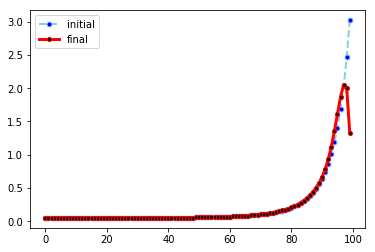

oxygen vacancy density


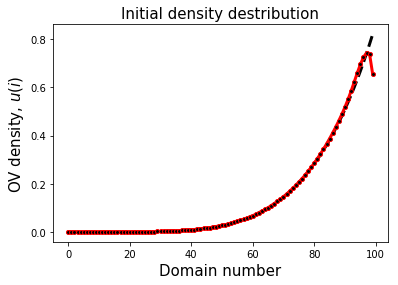

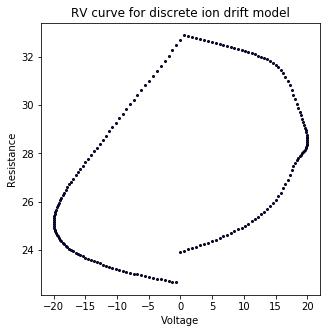

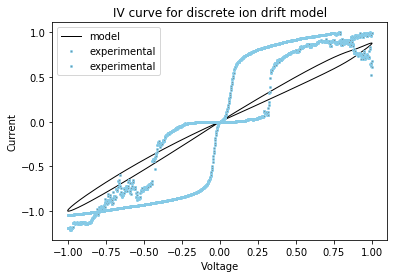

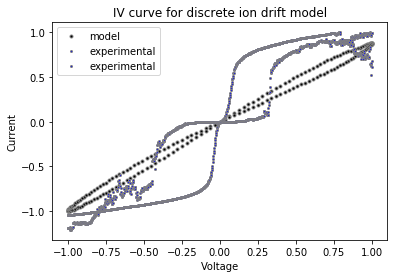

In [206]:
#resistivity and OV concentration on the last step
resistivityList = [_.resistivity for _ in nodes];
distribution = [_.delta for _ in nodes]


print('RESISTIVITY of each domain')
dfresistivity =pd.DataFrame({'x': range(n), 'yAxis': resistivityList0, 'yAxis2' : resistivityList})
plt.plot( 'x', 'yAxis', data=dfresistivity, marker='o', markerfacecolor='blue', markersize=5, color='skyblue', linewidth=2,linestyle='dashed', label = 'initial')
plt.plot( 'x', 'yAxis2', data=dfresistivity, marker='o', markerfacecolor='black', markersize=4, color='red', linewidth=3, label = 'final')
plt.legend()
plt.show()


print('oxygen vacancy density')
plt.figure(figsize=(6,4))
dfdensity =pd.DataFrame({'x': range(n), 'yAxis': distribution0, 'yAxis2': distribution})
plt.plot( 'x', 'yAxis', data=dfdensity, linestyle = '--', markerfacecolor='blue', markersize=6, color='black', linewidth=3)
plt.plot( 'x', 'yAxis2', data=dfdensity, marker='o', markerfacecolor='black', markersize=4, color='red', linewidth=3, label = 'final')
plt.title("Initial density destribution", fontsize= 15)
plt.xlabel(r'Domain number',fontsize=15)
plt.ylabel(r'OV density, $u(i)$', fontsize = 15)
#plt.legend()
plt.savefig('foo.pdf')
plt.show()



volts = np.concatenate((voltageBiasSet, voltageBiasReset))
ohms = np.concatenate((resistanceListSet, resistanceListReset))
amps = np.divide(volts,ohms)

voltsNorm = volts / np.amax(abs(volts)) 
ampsNorm = amps / np.amax(abs(amps))

dfresistance =pd.DataFrame({'x':volts, 'yAxis': ohms })
plt.figure(figsize=(5,5))
plt.plot( 'x', 'yAxis', data=dfresistance, marker='o', markerfacecolor='blue', markersize=2, color='black',  label = 'resistance', linestyle = 'none')
#plt.plot( 'x', 'yAxis2', data=dfdensity, marker='o', markerfacecolor='black', markersize=4, color='red', linewidth=3, label = 'final')
plt.title("RV curve for discrete ion drift model")
plt.xlabel("Voltage")
plt.ylabel("Resistance")
#plt.legend()
plt.show()





#reading and normalizing CSV data
dfExpData = pd.read_csv('image_a.csv')
for i in range(len(dfExpData.columns)):
    dfExpData.values[:,i] = dfExpData.values[:,i]/np.amax(dfExpData.values[:,i])

dfresistance =pd.DataFrame({'x':voltsNorm, 'yAxis': ampsNorm})
plt.figure(figsize=(6,4))
plt.plot( 'x', 'yAxis', data=dfresistance,  markerfacecolor='black', markersize=3, color='black', linestyle = '-', label = 'model', linewidth = '1')
plt.plot( dfExpData.values[:,0], dfExpData.values[:,1],  marker='o', markerfacecolor='gray', markersize=2, color='skyblue', linestyle = 'none', label = 'experimental')
plt.plot( dfExpData.values[:,2], dfExpData.values[:,3], marker='o',  markerfacecolor='gray', markersize=2, color='skyblue', linestyle = 'none', label = 'experimental')#
plt.title("IV curve for discrete ion drift model")
plt.xlabel(r'Number of cycles',fontsize=15)
plt.ylabel(r'Resistance', fontsize = 15)
plt.legend()
plt.show()


plt.figure(figsize=(6,4))
plt.plot( 'x', 'yAxis', data=dfresistance, marker='o', markerfacecolor='black', markersize=3, color='grey', linestyle = 'none', label = 'model')
plt.plot( dfExpData.values[:,0], dfExpData.values[:,1],  marker='o', markerfacecolor='blue', markersize=2, color='gray', linestyle = 'none', label = 'experimental')
plt.plot( dfExpData.values[:,2], dfExpData.values[:,3], marker='o',  markerfacecolor='blue', markersize=2, color='gray', linestyle = 'none', label = 'experimental')#
plt.title("IV curve for discrete ion drift model")
plt.xlabel("Voltage")
plt.ylabel("Current")
plt.legend()
plt.show()




In [192]:
print([sum(distribution), sum(distribution0)])

print([res0, resistance(nodes)])

print(np.min(ohms))
print(np.max(ohms))







[13.949102812261522, 13.94910281226152]
[23.866823354340845, 19.4062163398371]
19.4062163398371
25.35377793946013


# Resistance states degradation simulation

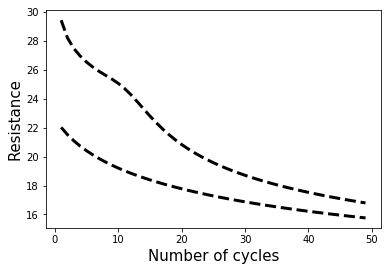

In [196]:

#
dfstates =pd.DataFrame({'x':range(1,cycles), 'yAxis': minmax[1:,0],'yAxis2':minmax[1:,1]})
plt.figure(figsize=(6,4))
plt.plot( 'x', 'yAxis', data=dfstates,  markerfacecolor='black',color='black', linewidth=3, linestyle = '--', label = 'model')
plt.plot( 'x', 'yAxis2', data=dfstates,  markerfacecolor='blue', color='black', linewidth=3, linestyle = '--', label = 'model')
plt.xlabel(r'Number of cycles',fontsize=15)
plt.ylabel(r'Resistance', fontsize = 15)
#plt.legend()
plt.savefig('states.png')
plt.show()

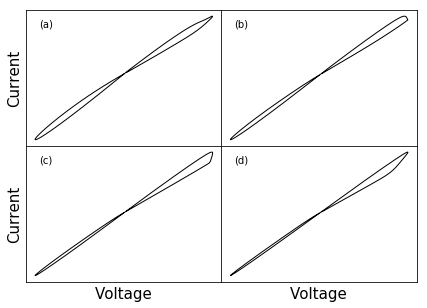

In [186]:
nodesStates = [Node(rho) for _ in range(n)]
volts = np.concatenate((voltageBiasSet, voltageBiasReset))
resistanceListSet = np.zeros(time)
resistanceListReset = np.zeros(time)
for i in range(n): 
    nodesStates[i].delta = (i**5)/((n+3)**5)+ np.random.normal(0,sigmaNoise)  

for i in range(1):
    resetResistance(nodesStates)
    setResistance(nodesStates)
ohms1 = np.concatenate((resistanceListSet, resistanceListReset))
amps1 = np.divide(volts,ohms1)
voltsNorm = volts / np.amax(abs(volts)) 
ampsNorm1 = amps1 / np.amax(abs(amps1))


for i in range(1):
    resetResistance(nodesStates)
    setResistance(nodesStates)        
ohms2 = np.concatenate((resistanceListSet, resistanceListReset))
amps2 = np.divide(volts,ohms2)
voltsNorm = volts / np.amax(abs(volts)) 
ampsNorm2 = amps2 / np.amax(abs(amps2))


for i in range(3):
    resetResistance(nodesStates)
    setResistance(nodesStates)        
ohms3 = np.concatenate((resistanceListSet, resistanceListReset))
amps3 = np.divide(volts,ohms3)
voltsNorm = volts / np.amax(abs(volts)) 
ampsNorm3 = amps3 / np.amax(abs(amps3))


for i in range(5):
    resetResistance(nodesStates)
    setResistance(nodesStates)        
ohms4 = np.concatenate((resistanceListSet, resistanceListReset))
amps4 = np.divide(volts,ohms4)
voltsNorm = volts / np.amax(abs(volts)) 
ampsNorm4 = amps4 / np.amax(abs(amps4))



dfiv =pd.DataFrame({'x':voltsNorm, 'yAxis1': ampsNorm1, 'yAxis2': ampsNorm2,'yAxis3': ampsNorm3,'yAxis4': ampsNorm4})

fig = plt.figure(figsize=(7,5))
fig.subplots_adjust(hspace=0, wspace=0)
ax = fig.add_subplot(2, 2, 1)
plt.plot( 'x', 'yAxis1', data=dfiv,  markerfacecolor='black', markersize=3, color='black', linestyle = '-', label = 'model',linewidth = '1')
plt.text(0.1, 0.9,'(a)', ha='center', va='center', transform=ax.transAxes)

plt.yticks([], [])
plt.xticks([], [])
plt.ylabel(r'Current',fontsize=15)

ax = fig.add_subplot(2, 2, 2)
plt.plot( 'x', 'yAxis2',data=dfiv,  markerfacecolor='black', markersize=3, color='black', linestyle = '-', label = 'model',linewidth = '1')
plt.text(0.1, 0.9,'(b)', ha='center', va='center', transform=ax.transAxes)
plt.xticks([], [])
plt.yticks([], [])

ax = fig.add_subplot(2, 2, 3)
plt.plot( 'x', 'yAxis3',data=dfiv,  markerfacecolor='black', markersize=3, color='black', linestyle = '-', label = 'model',linewidth = '1')
plt.text(0.1, 0.9,'(c)', ha='center', va='center', transform=ax.transAxes)
plt.yticks([], [])
plt.xticks([], [])
plt.ylabel(r'Current',fontsize=15)
plt.xlabel(r'Voltage',fontsize=15)

ax = fig.add_subplot(2, 2, 4)
plt.plot( 'x', 'yAxis4',data=dfiv,  markerfacecolor='black', markersize=3, color='black', linestyle = '-', label = 'model',linewidth = '1')
plt.text(0.1, 0.9,'(d)', ha='center', va='center', transform=ax.transAxes)
plt.yticks([], [])
plt.xticks([], [])
plt.xlabel(r'Voltage',fontsize=15)

plt.savefig('IVstates.png')
plt.show()



In [179]:
minmax[1:,0]

array([], dtype=float64)